In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# internal imports
from pympc.control.hybrid_benchmark.mixed_logical_dynamical_system import MixedLogicalDynamicalSystem
from pympc.control.hybrid_benchmark.controller_mld import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory

In [2]:
# system numeric parameters
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
h = .05

# state bounds
x_max = np.array([d, np.pi/6., 7., 5.])
x_min = - x_max

# input domain
u_max = np.array([20.])
u_min = - u_max

In [3]:
# symbolic states
x = sp.Matrix(sp.symbols('q t qd td'))

# symbolic continuous inputs
u = sp.Matrix([sp.symbols('u')])

# symbolic binary inputs
ub = sp.zeros(0,1)

# symbolic forces (left, right)
f = sp.Matrix(sp.symbols('fl fr'))

# symbolic auxiliary binaries (left, right)
b = sp.Matrix(sp.symbols('bl br'))

# dynamics
x_next = sp.Matrix([
    x[0] + h*x[2],
    x[1] + h*x[3],
    x[2] + h*((g*mp)/mc*x[1] + u[0]/mc),
    x[3] + h*(g*(mc+mp)/(l*mc)*x[1] + u[0]/(l*mc) - f[0]/(l*mp) + f[1]/(l*mp))
])

In [4]:
# state bounds
state_upper_bound = x - x_max.reshape(x_max.size, 1)
state_lower_bound = x_min.reshape(x_min.size, 1) - x

# input bounds
input_upper_bound = u - u_max.reshape(u_max.size, 1)
input_lower_bound = u_min.reshape(u_min.size, 1) - u

# contact left wall (big-M method)
# positive penetration: - d - x[0] + l*x[1]
left_force = sp.Matrix([
    - f[0],
    k*(- d - x[0] + l*x[1]) - f[0],
    f[0] - b[0]*k*(- d - x_min[0] + l*x_max[1]),
    f[0] - k*(- d - x[0] + l*x[1]) + (1. - b[0])*k*(- d - x_max[0] + l*x_min[1])
])

# contact right wall (big-M method)
# positive penetration: x[0] - l*x[1] - d
right_force = sp.Matrix([
    - f[1],
    k*(x[0] - l*x[1] - d) - f[1],
    f[1] - b[1]*k*(x_max[0] - l*x_min[1] - d),
    f[1] - k*(x[0] - l*x[1] - d) + (1. - b[1])*k*(x_min[0] - l*x_max[1] - d)
])

# gather constraints
constraints = sp.Matrix([
    state_upper_bound,
    state_lower_bound,
    input_upper_bound,
    input_lower_bound,
    left_force,
    right_force
])

In [5]:
# construct MLD system
variables = {'x':x, 'uc':u, 'ub':ub, 'sc':f, 'sb':b}
MLD = MixedLogicalDynamicalSystem.from_symbolic(variables, x_next, constraints)

In [43]:
# controller parameters
N = 50
weight_matrices = {}
weight_matrices['Q'] = 10.*np.eye(MLD.nx)*h/2.
weight_matrices['R'] = .1*np.eye(MLD.nuc)*h/2.
weight_matrices['P'] = weight_matrices['Q']

# hybrid controller
controller = HybridModelPredictiveController(MLD, N, weight_matrices)

In [44]:
x0 = np.array([0., 0., 2.5, 0.])

In [46]:
sol, leaves = controller.feedforward(x0, tree_file_name='tau_eq_0')

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.082            1                4.508            inf             
                   3.100            52               26.425           inf             
                   6.111            104              35.928           inf             
                   9.129            154              48.412           inf             
                   12.180           205              59.148           inf             
                   15.229           257              62.899           inf             
                   18.241           307              63.515           inf             
  New incumbent    19.207           324              63.516           63.516          
  Solution found   19.273           325              63.516           63.516          

Explored 325 nodes in 19.273 seconds: optim

In [52]:
np.random.seed(1)
e_max = 0.01
e_0 = e_max * np.random.randn(MLD.nx)
x_1 = sol['primal']['x'][1] + e_0
print e_0

[ 0.01624345 -0.00611756 -0.00528172 -0.01072969]


In [53]:
stage_variables = {
    'x_0' : sol['primal']['x'][0],
    'uc_0' : sol['primal']['uc'][0],
    'ub_0' : sol['primal']['ub'][0],
    'sc_0' : sol['primal']['sc'][0],
    'sb_0' : sol['primal']['sb'][0],
    'e_0' : e_0
}
warm_start = controller.construct_warm_start(leaves, stage_variables)

In [54]:
sol_1_ws, leaves_1_ws = controller.feedforward(x_1, tree_file_name='tau_eq_0_ws', warm_start=warm_start)

Loaded warm start with 161 nodes. Lower bound provided by the warm start is 49.869.
|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.095            1                50.177           inf             
                   3.146            45               64.946           inf             
                   6.187            91               65.282           inf             
                   9.207            134              65.477           inf             
                   12.271           180              65.699           inf             
  New incumbent    14.699           216              65.773           65.773          
  Solution found   14.779           217              65.773           65.773          

Explored 217 nodes in 14.779 seconds: optimal solution found with objective 65.773.


In [55]:
sol_1, leaves_1 = controller.feedforward(x_1, tree_file_name='tau_eq_1')

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.085            1                10.551           inf             
                   3.153            44               26.049           inf             
                   6.198            90               32.687           inf             
                   9.238            134              41.265           inf             
                   12.295           176              51.610           inf             
                   15.352           220              60.685           inf             
                   18.396           265              64.193           inf             
                   21.425           310              65.164           inf             
                   24.452           351              65.371           inf             
                   27.530           396     

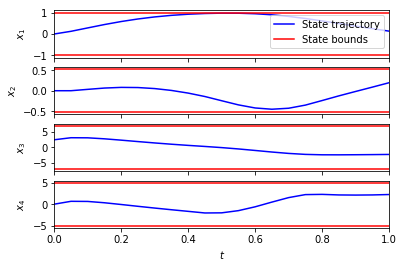

In [17]:
plot_input_sequence(sol['primal']['uc'], h, (u_min, u_max))
plt.savefig('input.pdf')
plot_state_trajectory(sol['primal']['x'], h, (x_min, x_max))
plt.savefig('state.pdf')

In [ ]:
plot_input_sequence(sol['primal']['sc'], h)
# plt.savefig('forces.pdf')

In [ ]:
plot_input_sequence(sol['primal']['sb'], h)
# plt.savefig('binaries.pdf')

In [ ]:
# output (horizontal position of the tip of the pole)
C = np.array([[1., -l, 0., 0.]])
y_min = np.array([-d])
y_max = np.array([d])
plot_output_trajectory(C, sol['primal']['x'], h, (y_min, y_max))
plt.savefig('output.pdf')

In [ ]:
from collections import OrderedDict
ident = OrderedDict([(('s', 0, 0), 0.0), (('s', 0, 1), 0.0)])

In [ ]:
sol = controller.solve_relaxation(x0, ident)[3]

In [ ]:
sol['primal']['sb_0']

In [ ]:
min(np.concatenate([sol[3]['dual']['lb_s_'+str(t)] for t in range(N)]))

In [ ]:
# print np.max(np.concatenate([v for v in sol['dual'].values()]))

In [ ]:
[sol['dual']['lb_s_%d'%t] for t in range(N)]
[np.concatenate((sol['dual']['lb_u_%d'%t], sol['dual']['lb_s_%d'%t])) for t in range(N)]

In [ ]:
import time
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

In [ ]:
vis = meshcat.Visualizer()

In [ ]:
# cart-pole
cart_pole = vis["cart_pole"]

# cart
cart = cart_pole["cart"]
cart.set_object(g.Box([.3*l, .3*l, .3*l]), g.MeshLambertMaterial(color=0xff2222))

# pivot
pivot = cart["pivot"]
pivot.set_transform(tf.rotation_matrix(np.pi/2, [1, 0., 0.]))

# pole
pole = pivot["pole"]
pole.set_object(g.Box([.05*l, l, .05*l]), g.MeshLambertMaterial(color=0x2222ff))
pole.set_transform(tf.translation_matrix([0., .5, 0.]))

# left wall
left_wall = vis["left_wall"]
left_wall.set_object(g.Box([l, .05*l, l]), g.MeshLambertMaterial(color=0x22ff22))
left_wall.set_transform(tf.translation_matrix([0., -d, l]))

# right wall
right_wall = vis["right_wall"]
right_wall.set_object(g.Box([l, .05*l, l]), g.MeshLambertMaterial(color=0x22ff22))
right_wall.set_transform(tf.translation_matrix([0., d, l]))

In [ ]:
# visualization function
def visualize_cart_pole(x):
    cart.set_transform(tf.translation_matrix([0, x[0], 0]))
    pivot.set_transform(tf.rotation_matrix(x[1] + np.pi/2, [1, 0, 0]))
vis.jupyter_cell()

In [ ]:
# animation
for t in range(N):
    visualize_cart_pole(sol['primal']['x'][t])
    time.sleep(h)